<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

# **Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

### Instructor: Enrique Naredo
### ET5003_Etivity-1

# Introduction
16154541 -
Darren White

### Explanation of the problem
The problem presented is to use Bayesian multinomial logistic regression to classify images from the MNIST database of handwritten digits.

# Dataset  
The MNIST database is a set of images of handwritten digits. The database contains 60,000 training images and 10,000 testing images. The database is based on the NIST database. The NIST database was compiled from American Census Bureau employees and high school students. The training set comes from the American Census Bureau employees and the testing set has been taken from American high school students. As a result of the difference between the groups it was posited that this database may not be efficient for machine learning.

The MNIST database is compiled as follows;

* 50% of the training data is taken from the NIST training set.
* 50% of the training data is taken from the NIST test set.
* 50% of the testing data is taken from the NIST training set.
* 50% of the testing data is taken from the NIST test set.

The MNIST database is maintained by Yann LeCun, (Courant Institute, NYU) Corinna Cortes, (Google Labs, New York) and Christopher J.C. Burges, (Microsoft Research, Redmond).

# Method  

Multinomial Logistic Regression (MLR) is used to classify the images in the MNIST database.  
  
MLR is an extension of Binary Logistic Regression (BLR) in which numerous binary models are deployed simultaneously.  
Multinomial logistic regression is used to classify categorial outcomes rather than continuous outcomes. Multinomial models do not assume normality, linearity or homoscedasticity. This makes it a strong modelling choice as real world data can often display these imperfections.


# Code

## Imports

In [1]:
from sympy import symbols

In [2]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [3]:
! pip install opencv-python
! pip install scikit-image
! pip install arviz

In [4]:
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import pymc3 as pm
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import random
import pickle
import arviz as az
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray
import numpy as np
from sklearn.datasets import fetch_openml

## Load Data

In [5]:
mnist = fetch_openml('mnist_784', cache=False)

In [6]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [7]:
X /= 255.0

In [8]:
X.min(), X.max()

(0.0, 1.0)

The use of `sklearn.datasets` through `fetch_openml()` to gather the MNIST dataset allows the notebook to run on both Google Colab and locally without change to the code.  

## Preprocessing

We split the MNIST data into a train and test set with 75% as training data and 25% as test data.

In [10]:
# assigning features and labels    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [12]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

In [60]:
def plot_example(X: np.array, y: np.array, n: int=5, plot_title: str=None) -> None:
    """Plots the first 'n' images and their labels in a row.
    
    Args:
        X (numpy array): Image data with each row of array contining an image
                         as a flat vector
        y (numpy array): Image labels
        n (int): Number of images to display
        plot_title (str): Title of the plot
    Returns:
        None
    """
    fig, axs = plt.subplots(1, n)
    fig.suptitle(plot_title, fontsize=20)

    axs = axs.ravel()
    for i, (img, y) in enumerate(zip(X[:n].reshape(n, 28, 28), y[:n])):
        axs[i].axis('off')
        axs[i].imshow(img, cmap="Greys_r")
        axs[i].set_title(y)
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()


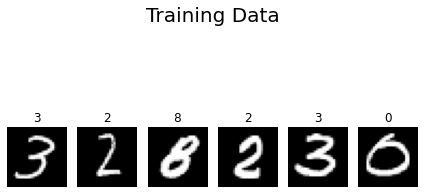

In [61]:
plot_example(X=X_train, y=y_train, n=6, plot_title="Training Data")

## Building a Number Classifier from the MNIST Database

A Bayesian Multinomial Logistic Regression (BMLR) shall be built to classify the handwritten numbers in the MNIST Database.

Multinomial logistic regression is a classifiaction technique that is used to predict the category of an input or the probability of its membership to a category. This is calculated based on multiple independent variables that are either binary or continuous. Multinomial logistic regression allows for the dependent variable to be part of more than two categories (Czepiel, n.d.)(Carpita, et al., 2014).

To build the classifier we must first understand its basic construction. The formula for BMLR is:  

$Pr(Y_{ik} = Pr(Y_i = k\mid x_i; \beta_1 , \beta_2 , ..., \beta_m) = \frac{\displaystyle\exp(\beta_{0k} + x_i \beta_k)}{\displaystyle\sum_{j=1}^{m}\exp(\beta_{0j} + x_i\beta_j)}$ with $k = 1,2,...$  

where $\beta_k$ is a row vector of regression coefficients of $x$ for the $k$th category of $y$  

Since multinomial logistic regression is an expansion of binary logistic regression we will first define a binary model.  

Logistic regression assumes that for a single data point $(x,y)$:  

$P(Y = 1 \mid X = x) = \sigma(z)$ where $z = \theta_0 + \displaystyle\sum_{i = 1}^{m} \theta_i x_i$  

where $\theta$ is a vector of parameters of length $m$ the values of these parameters is found from $n$ training examples.  
  
This is equivalent to:  
$P(Y =1 \mid X = x) = \sigma(\theta^Tx)$  

Maximum likelihood estimation (MLE) is used to choose the parameter values of the logistic regression. To do this we calculate the log-likelihood and find the values of $\theta$ that maximise it.  
  
Since the predictions being made are binary we can define each label as a Bernoulli random variable. The probability of one data point can thus be written as:  

$P(Y = y\mid X=x) = \sigma(\theta^Tx)^y \cdot [1 - \sigma(\theta^Tx)]^{(1-y)} $  

The likelihood of all of the data is defined as follows:  

The likelihood of the independent training labels:  

$L(\theta) = \displaystyle\prod_{i =1}^n P(Y = y^{(i)} \mid X = x^{(i)})$  

Using the likelihood of a Bernoulli we get  
$L(\theta) = \displaystyle\prod_{i =1}^n P(Y = y^{(i)} \mid X = x^{(i)}) = \displaystyle\prod_{i=1}^n\sigma(\theta^Tx^{(i)})^{y^{(i)}} \cdot [1-\sigma(\theta^Tx^{(i)})]^{(1-y^{(i)})}$  
  
Therefore the log-likelihood of the logistic regression is:  
  
$LL(\theta) = \displaystyle\sum_{(i=1)}^ny^{(i)}\log[\sigma(\theta^Tx^{(i)}) + (1 - y^{(i)}) \log[1 - \sigma(\theta^Tx^{(i)})]$  
  
By using a partial derivative of each parameter we can find the values of $\theta $ that maximise the log-likelihood.  

The partial derivative of $LL(\theta)$ is:  
  
$\frac{\partial LL(\theta)}{\partial\theta_j} = \displaystyle\sum_{i=1}^n [y^{(i)} - \sigma(\theta^Tx^{(i)})]x^{(i)}_j$  

Using this various optimisation techniques can be deployed to identify the maximum likelihood. A typical binary logistic regression might use gradient descent. However multinomial classifiers will likely use more sophisticated techniques (Monroe, 2017).
  

## Classifier

### Dataset Summary

In [64]:
# Number of training examples
n_train =  len(X_train)

# Number of testing examples.
n_test = len(X_test)

# Shape of an MNIST image
image_shape =X_train[0].shape

# unique classes/labels in the dataset.
alltotal = set(y_train )

# number of classes
n_classes = len(alltotal )

# print information
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 52500
Number of testing examples = 17500
Image data shape = (784,)
Number of classes = 10


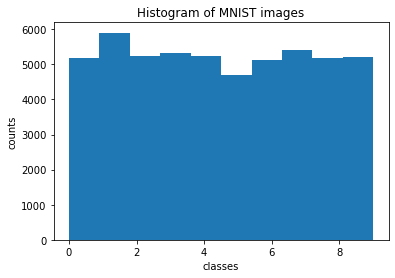

In [65]:
## plot histogram
fig, ax = plt.subplots()
# array with evenly spaced classes
ind = np.arange(n_classes)

# histogram
n, bins, patches = ax.hist(y_train, n_classes)
# horizontal axis label
ax.set_xlabel('classes')
# vertical axis label
ax.set_ylabel('counts')
# plot title
ax.set_title(r'Histogram of MNIST images')
# show plot
plt.show()

We can see from the histogram that we have a relatively balanced dataset which should create good conditions for classification

### Data Preparation

In [121]:
# Seed the run for repeatability
np.random.seed(0)

# The number of instances we'll keep for each of our 3 digits:
n_classes = 3
classes = [3, 7, 9]
N_per_class = 500

X = []
labels = []
for d in classes:
    imgs = X_train[np.where(y_train==d)[0],:]
    X.append(imgs[np.random.permutation(imgs.shape[0]),:][0:N_per_class,:])
    labels.append(np.ones(N_per_class)*d)

X_train2 = np.vstack(X).astype(np.float64)
y_train2 = np.hstack(labels)

We select all images indices of each desired class from `X_train`, randomly arrange them and append the first `inst_class` of them to the `inputs` array.

In [122]:
print(X_train2.shape,y_train2.shape)

(1500, 784) (1500,)


In [125]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

[8, 278, 418, 42, 440, 73, 171, 438, 332, 874, 934, 894, 938, 797, 727, 755, 738, 918, 1090, 1339, 1391, 1389, 1497, 1377, 1108, 1040, 1304]


Text(0.5, 1.0, 'Original Image Samples')

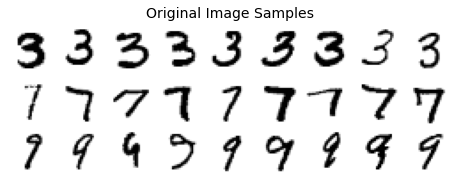

In [209]:
# Show random instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices from each of the 3 classes to show:
n_sample = 9
label_indices = []
for i in range(n_classes):
    label_indices += random.sample(range(i*N_per_class, (i+1)*N_per_class), n_sample)

print(label_indices)
# Plotting 'original' image
plot_digits(X_train2[label_indices,:],images_per_row=9)
plt.title("Original Image Samples", fontsize=14)

In [210]:
### we split the dataset in training and validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train2, y_train2, test_size=0.2, random_state=0)
 

X_tr, y_tr = shuffle(X_tr, y_tr)

print(X_tr.shape)
print(X_val.shape)
print(y_tr.shape)
print(y_val.shape)

(1200, 784)
(300, 784)
(1200,)
(300,)


In [211]:
# transform images into vectors  
X_trv = X_tr.flatten().reshape(X_tr.shape[0],X_tr.shape[1])
X_valv = X_val.flatten().reshape(X_val.shape[0],X_tr.shape[1])
print(X_trv.shape)
print(X_valv.shape)
print(y_tr.shape)
print(y_val.shape)

(1200, 784)
(300, 784)
(1200,)
(300,)


### Algorithm

In [212]:
#General-recipe ML logistic regression
clf = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_trv, y_tr)
y_pred_logi = clf.predict(X_valv)
y_pred_logi_prob = clf.predict_proba(X_valv)
prob_classmax = np.max(y_pred_logi_prob,axis=1)
print("Accuracy =", accuracy_score(y_pred_logi, y_val))

Accuracy = 0.92


Accuracy achieved of 0.92 is relatively good.  
We'll review the highest probablities for correctly and incorrectly classified images. 

In [213]:
# probability of general-recipe logistic regression in correct instances
highest_prob_matches = np.sort(prob_classmax[y_val==y_pred_logi])
print(f"Probabilities of best scoring matches:\n{highest_prob_matches}")

Probabilities of best scoring matches:
[0.52759847 0.53649911 0.61148141 0.75760889 0.84305141 0.86142344
 0.88610203 0.92352188 0.93861241 0.94588142 0.95209546 0.95807606
 0.9645845  0.9706558  0.97548346 0.97770509 0.97781796 0.97863509
 0.98032166 0.98252571 0.98476657 0.98552756 0.98726918 0.99087397
 0.99120579 0.99211836 0.9922619  0.99235484 0.99391533 0.99500037
 0.99529405 0.99585336 0.99605852 0.9962322  0.99637564 0.99660121
 0.99674794 0.99678878 0.99758973 0.99772594 0.9977375  0.99826268
 0.99869238 0.99869649 0.99892667 0.99910458 0.99923664 0.99938699
 0.99941404 0.99943481 0.99964417 0.99966432 0.99970071 0.99971825
 0.99972712 0.99977025 0.99978271 0.99982014 0.99982727 0.99984281
 0.99986186 0.99989331 0.99989408 0.99989694 0.99990313 0.99990613
 0.99990686 0.99991304 0.9999192  0.99992429 0.99993803 0.99994003
 0.99994345 0.99994712 0.99994801 0.99995426 0.9999584  0.99996427
 0.99996575 0.99996921 0.99996922 0.99997204 0.99997719 0.99997791
 0.99997852 0.99998015 

In [214]:
# probability of general-recipe logistic regression in wrong instances
highest_prob_mismatches = np.sort(prob_classmax[y_val!=y_pred_logi])
print(f"Probabilities of best scoring mismatches:\n{highest_prob_mismatches}")

Probabilities of best scoring mismatches:
[0.56975983 0.58842369 0.59648473 0.62136176 0.63660319 0.6992025
 0.72632888 0.74447906 0.77783398 0.7883539  0.81400985 0.85994637
 0.88533915 0.89710144 0.93168189 0.96980265 0.96981826 0.99620862
 0.99637427 0.99742931 0.99901251 0.99945591 0.99999838 0.99999904]


In [215]:
mismatch_indices_gt_99 = np.intersect1d(np.where(y_val!=y_pred_logi), np.where(prob_classmax > 0.99))
print(f"Mismatch count above 99% probability : {len(mismatch_indices_gt_99)}")

Mismatch count above 99% probability : 7


Comparison of actual vs predicted: 
y_pred:7.0 y_val:9.0
y_pred:7.0 y_val:9.0
y_pred:9.0 y_val:7.0
y_pred:9.0 y_val:7.0
y_pred:7.0 y_val:9.0
y_pred:9.0 y_val:7.0
y_pred:7.0 y_val:9.0



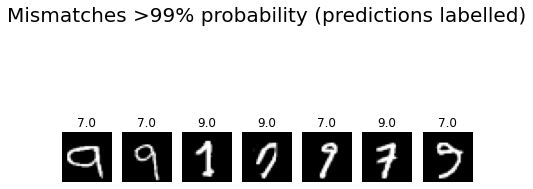

In [237]:
# Display mismatches above 99% probability
display_cnt = len(mismatch_indices_gt_99)

X_valv_mismatches = []
y_val_mismatches = []
y_pred_mismatches = []
compare = 'Comparison of actual vs predicted: \n'
for idx in mismatch_indices_gt_99:
    X_valv_mismatches.append(X_valv[idx])
    y_val_mismatches.append(y_val[idx])
    y_pred_mismatches.append(y_pred_logi[idx])
    compare += "y_pred:"+str(y_pred_logi[idx])+" y_val:"+str(y_val[idx])+"\n"

X_valv_mismatches = np.array(X_valv_mismatches)
y_val_mismatches = np.array(y_val_mismatches)
y_pred_mismatches = np.array(y_pred_mismatches)

print(compare)
plot_example(X=X_valv_mismatches, y=y_pred_mismatches,
             n=display_cnt, plot_title="Mismatches >99% probability (predictions labelled)")

We observe seven of the wrong predictions by logistic regression having a confidence above 99%. On reviewing the images it is difficult to understand how these have been labelled with such high confidence incorrectly. 

### Probabilistic ML

In [87]:
import sklearn.preprocessing
## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_tr.reshape(-1,1))
nf = X_trv.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_trv,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

In [88]:
y_2_bin

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [89]:
with multi_logistic:
    #approx = pm.fit(300000, method='advi') # takes longer
    approx = pm.fit(3000, method='advi')

Finished [100%]: Average Loss = 8,159.4


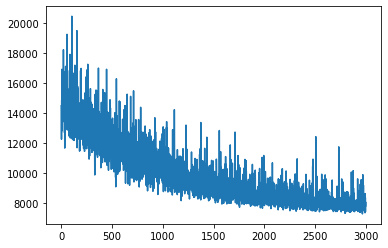

In [90]:
plt.plot(approx.hist)

In [91]:
dd = 300
posterior = approx.sample(draws=dd)

test image #10
posterior sample #100
true class= 9.0
classes: [3, 7, 9]
estimated prob= [0.00000367 0.01202809 0.98796824]


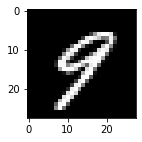

In [92]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_valv[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_valv[i,:].dot(beta) + alpha])))[0,:])

In [93]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_valv.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_valv[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [94]:
print(y_pred_Bayesian)

[0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 1, 2, 2, 0, 2, 0, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 0, 1, 0, 0, 2, 2, 2, 2, 0, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 0, 2, 0, 1, 0, 0, 2, 1, 1, 1, 0, 2, 1, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 2, 0, 2, 0, 0, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 2, 1, 1, 1, 2, 0, 0, 0, 1, 2, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 2, 2, 0, 2, 1, 1, 2, 1, 0, 1, 1, 1, 0, 2, 2, 0, 0, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 1, 2, 0, 2, 2, 1, 2, 2, 2, 1, 0, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 2, 2, 0, 1, 2, 0, 1, 1, 2, 0]


In [95]:
# recall the classes we are using
print(classes)

[3, 7, 9]


In [96]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([3, 3, 9, 3, 9, 3, 7, 3, 3, 3])

In [97]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.9133333333333333


### Selecting Differences

In [98]:
y_predB=[]

for i in range(X_valv.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_valv[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [99]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.91560237, 0.2712932 ],
       [0.        , 0.96531667, 0.16110728],
       [2.        , 0.97497298, 0.11469767],
       [0.        , 0.9977625 , 0.05763872],
       [2.        , 0.99925193, 0.        ],
       [0.        , 0.59659325, 0.49056657],
       [1.        , 0.97294036, 0.15095989],
       [0.        , 0.75855252, 0.41647996],
       [0.        , 0.98927811, 0.09949874],
       [0.        , 0.56756043, 0.49355851]])

In [100]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[2.        , 0.48764648, 0.49989999],
       [2.        , 0.50492672, 0.49972215],
       [2.        , 0.51166477, 0.49972215],
       [1.        , 0.51745938, 0.49959984],
       [2.        , 0.47822369, 0.49959984],
       [2.        , 0.46780942, 0.49945526],
       [2.        , 0.45491828, 0.49945526],
       [1.        , 0.51115171, 0.49945526],
       [1.        , 0.47469922, 0.49928838],
       [1.        , 0.52197469, 0.49928838]])

In [101]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi != y_val]

array([0.81385627, 0.96979209, 0.99999838, 0.99638025, 0.58898771,
       0.72644393, 0.88519093, 0.99742265, 0.62094863, 0.99619947,
       0.96971074, 0.6998873 , 0.59617169, 0.57061054, 0.99945618,
       0.99901171, 0.78862397, 0.93174525, 0.89717124, 0.77768554,
       0.99999904, 0.63573319, 0.74382678, 0.86027192])

In [102]:
y_predB[y_pred_logi != y_val,:]

array([[2.        , 0.59571687, 0.49243161],
       [2.        , 0.87327071, 0.31699982],
       [1.        , 0.86739133, 0.32881944],
       [2.        , 0.89926387, 0.2763854 ],
       [2.        , 0.45491828, 0.49945526],
       [1.        , 0.56702113, 0.49408726],
       [0.        , 0.64341373, 0.4748216 ],
       [0.        , 0.90619991, 0.26606181],
       [1.        , 0.59466919, 0.49056657],
       [2.        , 0.96928809, 0.14      ],
       [2.        , 0.46780942, 0.49945526],
       [2.        , 0.64613198, 0.4769696 ],
       [2.        , 0.8752776 , 0.32102267],
       [1.        , 0.51745938, 0.49959984],
       [1.        , 0.8956784 , 0.2763854 ],
       [2.        , 0.75326888, 0.42503595],
       [1.        , 0.58872244, 0.49056657],
       [0.        , 0.98988328, 0.09949874],
       [0.        , 0.94876146, 0.20360637],
       [2.        , 0.52656469, 0.49865374],
       [1.        , 0.9162603 , 0.2763854 ],
       [0.        , 0.42340732, 0.49408726],
       [2.

In [103]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_logi[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_logi[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 0.98
Accuracy in difficult instances = 0.87


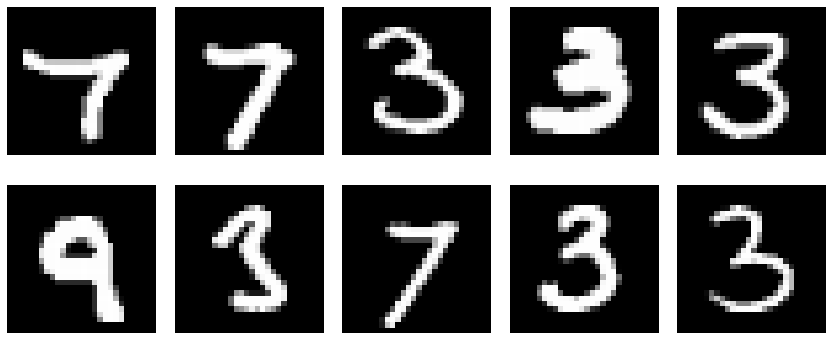

In [104]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_valv[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

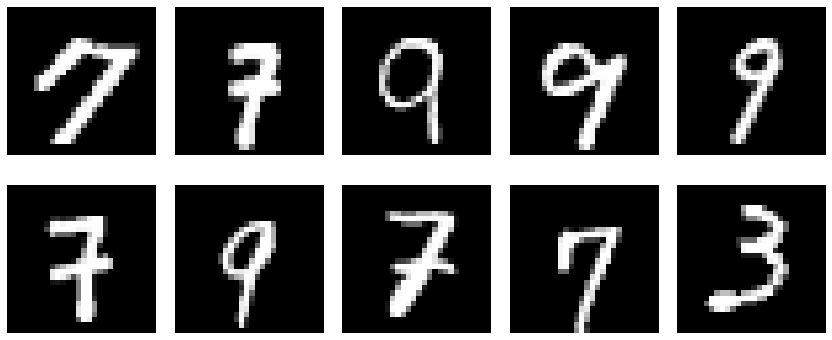

In [105]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_valv[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

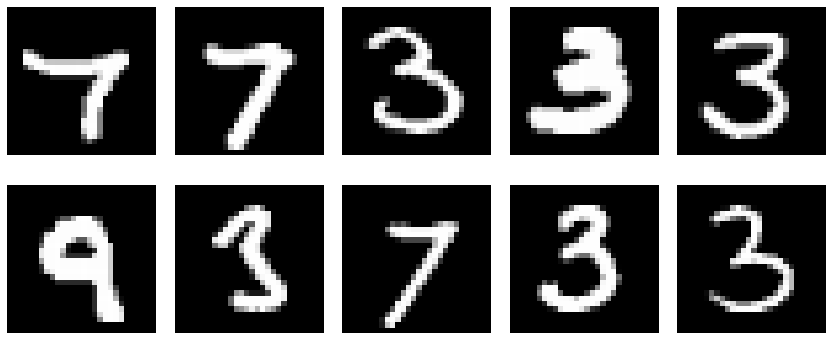

In [106]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_valv[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

Predicted answers - easy

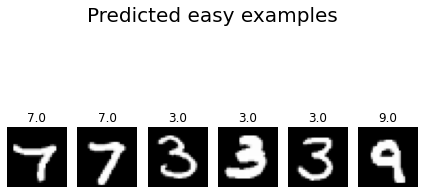

In [108]:
plot_example(X=X_valv[easy], y=y_pred_logi[easy], n=6, plot_title="Predicted easy examples")

Actual answers - easy

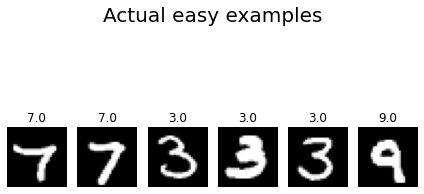

In [109]:
plot_example(X=X_valv[easy], y=y_val[easy], n=6, plot_title="Actual easy examples")

Predicted answers - difficult

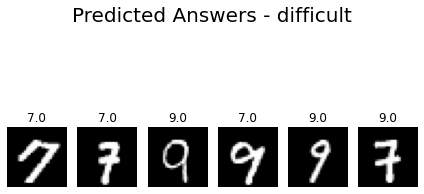

In [111]:
plot_example(X=X_valv[difficult], y=y_pred_logi[difficult], n=6, plot_title="Predicted Answers - difficult" )

Actual answers - difficult

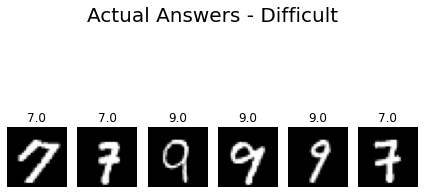

In [112]:
plot_example(X=X_valv[difficult], y=y_val[difficult], n=6, plot_title="Actual Answers - Difficult")

# Summary

We have developed a Bayesian classification model that accuracy classifies the MNIST Database using the lbfgs optimiser. The lbfgs optimiser is a limited memory algorithm used for solving optimisation problems in nonlinear problems. This was developed by Ciyou Zhu, Richard H. Byrd, Peihuang Lu and Jorge Nocedal in 1994.

We have been able to achieve an accuracy level of 92% which is relatively high. However, using large convolutional neural network other researchers have achieved accuracy rates above 99%.


# References

## Bibliography
Böhning, D., 1992. Multinomial logistic regression algorithm. Annals of the Institute of Statistical Mathematics, Volume 44, pp. 197-200.

Carpita, M., Sandri, M., Simonetto, A. & Zuccolotto, P., 2014. Chapter 14 - Football Mining with R. In: Y. Zhao & Y. Cen, eds. Data Mining Applications with R. s.l.:Academic Press, pp. 397-433.

Czepiel, S. A., n.d. Maximum Likelihood Estimation of Logistic Regression Models: Theory and Implementation. [Online] 
Available at: https://czep.net/stat/mlelr.pdf
[Accessed 12 September 2021].

Koehrsen, W., 2018. Introduction to Bayesian Linear Regression. [Online] 
Available at: https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7
[Accessed 12 September 2021].

Monroe, W., 2017. Stanford.edu. [Online] 
Available at: https://web.stanford.edu/class/archive/cs/cs109/cs109.1178/lectureHandouts/220-logistic-regression.pdf
[Accessed 12 September 2021].

Scikit, 2021. sklearn.linear_model.LogisticRegression. [Online] 
Available at: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
[Accessed 12 September 2021].

Sperandei, S., 2014. Understanding logistic regression analysis. Biochem med, 24(1), pp. 12-18.
Starkweather, J. & Moske, A. K., 2011. Multinomial Logistic Regression. [Online] 
Available at: https://it.unt.edu/sites/default/files/mlr_jds_aug2011.pdf
[Accessed 14 September 2021].

